<a href="https://colab.research.google.com/github/juanigp/simple-style-transfer/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
import torch
import torch.nn as nn
from torchvision import transforms, models

Content and style images

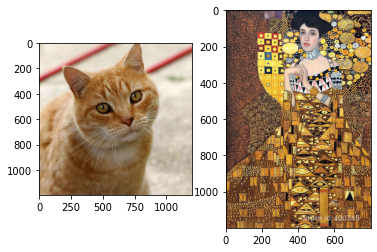

In [28]:
content_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg'
response = requests.get(content_url)
content_image = Image.open(BytesIO(response.content))

style_url = 'https://ae01.alicdn.com/kf/HTB1tFiwwuuSBuNjSsplq6ze8pXaX/Gustav-Klimt-Portr-t-von-Adele-Bloch-Bauer-Leinwand-Kunstwerk-Frau-Gold-Gem-lde-l-Kunst.jpg_Q90.jpg_.webp'
response = requests.get(style_url)
style_image = Image.open(BytesIO(response.content))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(content_image)
axs[1].imshow(style_image)

Hook class to get the model's activations, Gram matrix

In [6]:
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

def gram_matrix(input):
    a, b, c, d = input.size()  
    features = input.view(a, b, c * d)
    gram_matrix = torch.bmm(features, torch.transpose(features,1,2))
    return gram_matrix.div(a * b * c * d)

Lets use a VGG16 model

In [4]:
model = models.vgg16(pretrained = True).cuda()
model.requires_grad = False
model.eval()


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Style transfer! Usually we need to play with the content and style weights values, number of iterations

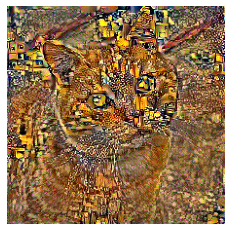

In [41]:
#transforms
imagenet_normalize = transforms.Normalize(
    mean=(0.485, 0.456, 0.406), 
    std=(0.229, 0.224, 0.225)
)

input_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(224),
  imagenet_normalize
])

out_transform = transforms.Compose([
  transforms.ToPILImage(),
])

#list of relu layers of our model (we can check this from the model.eval() output)
vgg_layers = [model.features[1], model.features[3], model.features[6],
              model.features[8], model.features[11], model.features[13],
              model.features[15],model.features[18],model.features[20],
              model.features[22],model.features[25],model.features[27],
              model.features[29]]

#list of hooks, for every relu layer
vgg_layers_hooks = [Hook(layer) for layer in vgg_layers]
#layer we will use for the content loss
content_layer_idx = 5
content_layer_hook = vgg_layers_hooks[content_layer_idx]

#content image tensor
content_tensor = input_transform(content_image).cuda().unsqueeze(0)
#content activations from the layer we chose
model_out = model(content_tensor)
content_features = content_layer_hook.output.detach()

#style image tensor
style_tensor = input_transform(style_image).cuda().unsqueeze(0)
#style activations from all the relu layers
model_out = model(style_tensor)
style_features_list = [hook.output.detach() for hook in vgg_layers_hooks]

#pastiche tensor we will use to create the new image
pastiche_tensor = torch.rand(content_tensor.shape).cuda() * 0.1
pastiche_tensor.requires_grad = True

#number of iterations
iters = 100
#weight for our content loss
content_weight = 0.03
#weights for each of the relu layers, for our style loss
style_weights = 2000 * [3,3,1,0,1,2,2,0,3,0,1,0,0]
#l1 loss, optimizer
l1loss = torch.nn.L1Loss()
optimizer = torch.optim.AdamW([pastiche_tensor], lr = 0.05)

for i in range(iters):
  #we need to clamp the values of our pastiche tensor
  pastiche_tensor.data.clamp_(0, 1)
  #features produced by the pastiche tensor
  pastiche_tensor_ = imagenet_normalize(pastiche_tensor)
  model_out = model(pastiche_tensor_)
  pastiche_features_list =  [hook.output for hook in vgg_layers_hooks]
  #content loss
  content_loss = content_weight * l1loss(pastiche_features_list[content_layer_idx], content_features)
  #style loss
  style_loss = 0
  for pastiche_features, style_features, style_weight in zip(pastiche_features_list, style_features_list, style_weights):
    style_loss += style_weight * l1loss(gram_matrix(pastiche_features), gram_matrix(style_features))
  loss = content_loss + style_loss
  #backward pass and optimizer step
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

#a final clamp and lets see!
pastiche_tensor = pastiche_tensor.squeeze(0).data.clamp_(0,1)
new_img = out_transform(pastiche_tensor)
plt.axis('off')
plt.imshow(new_img)